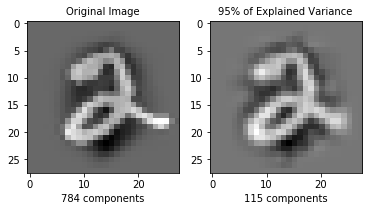

In [3]:
# References:
# 1. Image deskew: https://fsix.github.io/mnist/Deskewing.html

import timeit
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy.ndimage import interpolation
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.linalg import svd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Functions to deskew the images
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix


def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

# Start the time to capture runtime
start = timeit.default_timer()

# Read the training data
data = np.genfromtxt("/Users/shrilekha/Downloads/mnist_train.txt", delimiter=',')
label = data[:,0]
pixel = data[:,1:]

# Deskew the  training data data 
Deskewed_training_data =  deskewAll(pixel)

# Center the training data
center = preprocessing.StandardScaler(with_std=False).fit(Deskewed_training_data)
train_X = center.transform(Deskewed_training_data)

# Applying PCA to train data
pca = PCA(0.95)
pca = pca.fit(train_X)
reduced_data = pca.fit_transform(train_X) # This has reduced the data without loosing 95 % variance of the data.

approximation = pca.inverse_transform(reduced_data)

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_X[5].reshape(28,28),
              cmap = plt.cm.gray,interpolation='nearest')
plt.xlabel('784 components', fontsize = 10)
plt.title('Original Image', fontsize = 10);

# 115 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[5].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest');
plt.xlabel('115 components', fontsize = 10)
plt.title('95% of Explained Variance', fontsize = 10);


# Read the test data
data_2 = np.genfromtxt("/Users/shrilekha/Downloads/mnist_test.txt", delimiter=',')

# Deskweing test data
Deskewed_test_data = deskewAll(data_2[:,1:])

# Centering test data
center_test = preprocessing.StandardScaler(with_std=False).fit(Deskewed_test_data)
test_X = center.transform(Deskewed_test_data)

# PCA tranformation
reduced_test_data = pca.transform(test_X)

In [ ]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import timeit

start = timeit.default_timer()
model_l = OneVsOneClassifier(SVC(kernel='linear', C = 3))
clf_l =  model_l.fit(reduced_data, label)
y_pred_l = clf_l.predict(reduced_test_data)
accuracy_l = accuracy_score(data_2[:,0], y_pred_l)
error_rate_l = 1 - accuracy_l
print(error_rate_l)
    
end = timeit.default_timer()
print("Total time taken in Linear SVM OVO %s sec"%(end-start))    


In [36]:
# Implemented  SVM (kernal  = third degree polynomial) classifier


from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


start = timeit.default_timer()

C_range = [.001, 0.1,1,100,100000]
for i in C_range:
    model = OneVsOneClassifier(SVC(kernel='poly',degree=3, C = i))
    clf =  model.fit(reduced_data, label)
    y_pred = clf.predict(reduced_test_data)
    accuracy = accuracy_score(data_2[:,0], y_pred)
    error_rate = 1 - accuracy
    print(error_rate)
    
end = timeit.default_timer()
print("Total time taken in Poly SVM OVO %s sec"%(end-start))    


0.011600000000000055
0.011600000000000055
0.011600000000000055
0.011600000000000055
0.011600000000000055
Total time taken in Poly SVM OVO 784.987693513991 sec


In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import timeit


start = timeit.default_timer()

C_range = [.001, 0.1,1,100,100000]
for i in C_range:
    model_2p = OneVsRestClassifier(SVC(kernel='poly',degree=3, C = i))
    clf_2p =  model_2p.fit(reduced_data, label)
    y_pred_2p = clf_2p.predict(reduced_test_data)
    accuracy_2p = accuracy_score(data_2[:,0], y_pred_2p)
    error_rate_2p = 1 - accuracy_2p
    print(error_rate_2p)
    
end = timeit.default_timer()
print("Total time taken in Poly SVM OVR %s sec"%(end-start))

0.01200000000000001
0.01200000000000001
0.01200000000000001
0.01200000000000001
0.01200000000000001
Total time taken in Poly SVM OVR 3374.0007688180012 sec


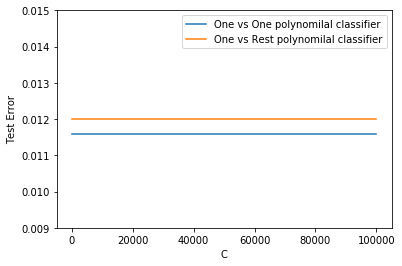

In [23]:
# Plotting Error Curve for various C 
x = [.001, 0.1,1,100,100000]
y = [0.011600000000000055,0.011600000000000055,0.011600000000000055,0.011600000000000055,0.011600000000000055]
plt.plot(x,y, label ="One vs One polynomilal classifier")
plt.ylabel('Test Error')
plt.xlabel('C')
plt.ylim((0.009,0.015))
plt.legend()

x = [.001, 0.1,1,100,100000]
y = [0.01200000000000001,0.01200000000000001,0.01200000000000001,0.01200000000000001,0.01200000000000001]
plt.plot(x,y, label ="One vs Rest polynomilal classifier")
plt.ylabel('Test Error')
plt.xlabel('C')
plt.ylim((0.009,0.015))
plt.legend()


In [ ]:
start = timeit.default_timer()

X_train, _, y_train, _ = train_test_split(train_pixel, train_label, test_size=0.95, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=42)
X_train[X_train>0]=1
X_test[X_test>0]=1

# generate matrix with all C
C_range = np.outer(np.logspace(-1, 1, 3),np.array([1,5]))
C_range = C_range.flatten()

gamma_range = np.outer(np.logspace(-3, 0, 4),np.array([1,5]))
gamma_range = gamma_range.flatten()

parameters = {'kernel':['rbf'], 'C':C_range, 'gamma': gamma_range}
clf = GridSearchCV(estimator=SVC(), param_grid=parameters, n_jobs=1, verbose=2, cv=3)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

end = timeit.default_timer()
print("Total time taken %s sec"%(end-start))

In [ ]:
# Now predict the value of the test
expected = test_label
test_pixel[test_pixel>0]=1
predicted = clf.predict(test_pixel)

# show_some_digits(X_test,predicted,title_text="Predicted {}")

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))
      
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

plot_confusion_matrix(cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))